# Averaged Kalman gain for the core monsoon region and each proxy record.

* First, mapplot of the region

* use the decadal kalman gain (also keep an option)


In [11]:
import sys
sys.path.append('/home/mchoblet/paleoda')
import xarray as xr
from adjustText import adjust_text
import utils
import dataloader
import wrapper
import dataloader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    
import utils
import copy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
az=xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_az_10.nc')
quel=xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/quelcaya_az.nc')
ma=xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_ma.nc')
quel['sitename']='Quelccaya Ice Cap'
proxies=[az,ma,quel]

In [3]:
bounds_europe=[[30,85],[310,50]]
bounds_global=[[-90,90],[0,360]]
bounds_sa=[[-57.5,15],[270,330]]
bounds_america=[[-60,30],[240,330]]
monsoon_region=[[-17.5,-5],[287.5,312.5]] #Vuille 2012

In [37]:
echam_bsp=xr.open_dataset('/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc')
data=echam_bsp
#cut fields
lat=data.lat
lon=data.lon

10

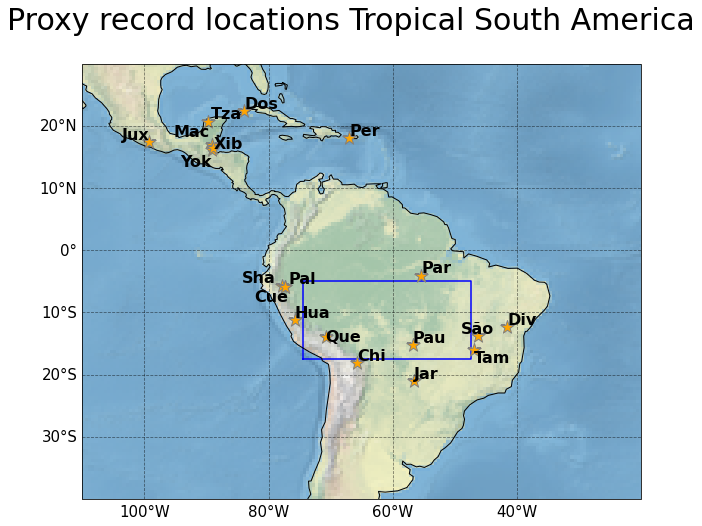

In [12]:
figsize=(12,8)
#title=''#'Bubumap'
title='Proxy record locations Tropical South America'#'Bubumap'
bounds=monsoon_region

fig, axes = plt.subplots(ncols=1,nrows=1,figsize=figsize,subplot_kw={'projection':ccrs.PlateCarree()})
fig.suptitle(title,fontsize=30)
ax=axes

ax.add_feature(cfeature.COASTLINE,zorder=1)
gl=ax.axes.gridlines(color='black',alpha=0.5,linestyle='--',draw_labels=True, dms=True, x_inline=False, y_inline=False)
#ax.plot([285.5,312.5,312.5,285.5,285.5],[-17.5,-17.5,-5,-5,-17.5], transform=ccrs.PlateCarree(),color='blue')
gl.top_labels = False
gl.right_labels = False

ax.axes.xaxis.set_visible(True)
ax.axes.yaxis.set_visible(True)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_extent([250,340,-40,30,], crs=ccrs.PlateCarree())
ax.stock_img()

"""
lats,lons=bounds[0],bounds[1]
if lons[0]<lons[1]:    #selection of longitudes
    sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
    sel_lon = lon.where( (lon >= lons[0] ) & (lon <= lons[1]), drop=True)
else:    #cross zero-meridian region option
    sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
    sel_lon_1 = lon.where( (lon >= lons[0] ), drop=True)
    sel_lon_2 = lon.where((lon <= lons[1]), drop=True)
    sel_lon=xr.concat([sel_lon_1,sel_lon_2],dim='lon')
"""

names=[]
locs=[]
ax.plot([285.5,312.5,312.5,285.5,285.5],[-17.5,-17.5,-5,-5,-17.5], transform=ccrs.PlateCarree(),color='blue',zorder=0)

for p in proxies:
    scatter=ax.scatter(p.lon,p.lat,c='orange',s=200, transform=ccrs.PlateCarree(),marker='*', edgecolors='grey',zorder=1)
    for prox in p.site:
        p_prox=p.sel(site=prox)
        name=p_prox['sitename'].values.tolist()
        x=np.random.randint(5)
        y=np.random.randint(5)
        names.append(name[:3])
        locs.append((p_prox.lon.values.tolist(),p_prox.lat.values.tolist()))
        #plt.annotate(name[:3],xy=(p_prox.lon-x,p_prox.lat-y),fontsize=16,transform=ccrs.PlateCarree(),)
    
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

texts = [ax.text(locs[i][0], locs[i][1], names[i], ha='center', color='black',weight='bold',
            va='center',transform=ccrs.PlateCarree(),fontsize=16) for i in range(len(locs))]
    
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'), ax=ax,color='black')
adjust_text(texts, ax=ax,color='black')

#data_cut=data.sel(lat=sel_lat,lon=sel_lon)
#plot=data_cut['tsurf'][0].plot(vmax=0,vmin=0,ax=ax,cmap='RdBu_r',add_colorbar=False)

In [146]:
fig.savefig('/home/mchoblet/plots_thesis/6_2/locations.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

# Mean Kalman gain for core monsoon region grid cells 

1. Loop over models:
    - load model d18O,temp, prec, evap
    - select core monsoon region grid cells, resample to 10 years
    
2. Loop over proxy dbs (set psm accordingly)
- PSM apply 
- Loop over proxies
- Kalman gain by hand for each grid cell temp/prec
- compute mean kalman gain (area weighted)
- save result in a list

3. Multi-model ensemble?

3. After model loop: Pandas dataframe, sns swarmplot (see plots for 5_4)

In [13]:
paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/CESM_inf_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/CCSM_inf_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_inf_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/GISS_inf_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc',
'inf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_inf_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc',
       }
} 

In [14]:
cfg={}
cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_az_10.nc','/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_ma.nc','/home/mchoblet/paleoda/data/proxy_dbs/quelcaya_az.nc']
cfg['obs_var']=[['d18O','d18O_precision'],['d18O','d18O_precision'],['d18O','d18O_precision']]
cfg['proxy_error']=[0.2,0.2,0.2] 
cfg['psm']=['speleo','speleo','icecore']
cfg['var_psm']=['d18O','d18O','d18O'] 
#irrelevant if psm=none
cfg['speleo']={
    'weighting': 'inf',#'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation': True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
}
cfg['icecore']={
    'weighting':'prec', #None(pure d18O) / prec (d180 prec weighted)
    'height': False, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
}
cfg['proxy_time']=['0500','1999']
cfg['only_regional_proxies']=False
cfg['ppe']={'use':False}

cfg['avg']=None
cfg['check_nan']=True
cfg['interpol']=None

In [ ]:
cfg[]

In [96]:
from types import SimpleNamespace

dic_mod={}
priors=[]
HX_array=[]

#loop models:
for mod in paths.keys():
    cfg['vp']=paths[mod]
    
    c=SimpleNamespace(**cfg)
    prior, attributes, prior_raw=utils.prior_preparation(c)
    prior=prior.sel(time=slice('0851','1849'))
    prior_raw=prior_raw.sel(time=slice('0851','1849'))
    pp_y_all,pp_r_all=utils.proxy_load(c)
    
    HXfull_all=utils.psm_apply(c,prior,prior_raw, pp_y_all)
    HXfull_all[2]['sitename']='Quelcaya ice cap'

    #HXfull=[H.resample(time='10YS').mean('time') for H in HXfull_all]
    HXfull=[H.rolling(time=10, center=True).mean().dropna('time') for H in HXfull_all]
    #HXfull=HXfull_all
    HX_array.append(HXfull)
    
    monsoon_region=[[-17.5,-5],[287.5,312.5]]

    lons=monsoon_region[1]
    lats=monsoon_region[0]

    lat=prior.lat
    lon=prior.lon

    #selection of longitudes
    if lons[0]<lons[1]:
        #import pdb
        #pdb.set_trace()
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon = lon.where( (lon >= lons[0] ) & (lon <= lons[1]), drop=True)
    #cross zero-meridian region option
    else:
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon_1 = lon.where( (lon >= lons[0] ), drop=True)
        sel_lon_2 = lon.where((lon <= lons[1]), drop=True)
        sel_lon=xr.concat([sel_lon_1,sel_lon_2],dim='lon')

    #field_m=prior.sel(lat=sel_lat,lon=sel_lon)#.resample(time='10YS').mean('time')
    field_m=prior.sel(lat=sel_lat,lon=sel_lon).rolling(time=10, center=True).mean().dropna('time')#.resample(time='10YS').mean('time')
    priors.append(field_m)
    
   
    
    dic={}

    var='tsurf'
    vals=[]
    names=[]
    
    #for _ in range(10):
     #   idx=dataloader.random_indices(100,990,seed=None)[0]
    val_a=[]
    for proxs in HXfull:
        for site in proxs.site:
            bu=proxs.sel(site=site)
            #xr.cov(field_m[var],bu,dim='time')
            val=xr.cov(field_m[var][idx],bu[idx],dim='time')/(np.cov(bu)+0.2)
            lat=field_m.lat
            wgt=np.cos(np.deg2rad(lat))
            val=val.weighted(wgt).mean(('lat','lon'))
            vals.append(val.values.tolist())
    #val_a.mean(axis=0)
    #vals.append(val_a)
            names.append(val.sitename.values.tolist())
    dic[var]=vals

    var='prec'
    vals=[]
    #for _ in range(10):
    #    idx=dataloader.random_indices(100,990,seed=None)[0]
    #    val_a=[]
    for proxs in HXfull:
        for site in proxs.site:
            bu=proxs.sel(site=site)
            #xr.cov(field_m[var],bu,dim='time')
            val=xr.cov(field_m[var][idx],bu[idx],dim='time')/(np.cov(bu)+0.2)
            lat=field_m.lat
            wgt=np.cos(np.deg2rad(lat))
            val=val.weighted(wgt).mean(('lat','lon'))
            vals.append(val.values.tolist())
    #val_a.mean(axis=0)
    #vals.append(val_a)

    dic[var]=vals
    
    dic_mod[mod]=dic
    

Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load inf  from  /home/mchoblet/paleoda/data/model_data/CESM_inf_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
>>>>>LOADING PROXY DATA
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
Checking prior for nans
Checking prior for nans
Checking prior for nans
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
Checking prior for nans
Checking prior for nans
Checking prior for nans
>>>>>>>>>>>>>APPLYIN

In [86]:
import pandas as pd

In [87]:
model_names=np.concatenate([np.repeat(p,19) for p in paths.keys()])
loc_names=np.tile(names,5)
prec_vals=np.concatenate([pd.DataFrame(dic_mod).T['prec'][mod] for mod in paths.keys()])
tsurf_vals=np.concatenate([pd.DataFrame(dic_mod).T['tsurf'][mod] for mod in paths.keys()])

all_data={'locs':loc_names,'model':model_names,'prec':prec_vals,'tsurf':tsurf_vals}
df=pd.DataFrame(all_data)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'Paraiso cave'),
  Text(1, 0, 'Jaraguá cave'),
  Text(2, 0, 'Palestina cave'),
  Text(3, 0, 'Tamboril cave'),
  Text(4, 0, 'Diva cave'),
  Text(5, 0, "Pau d'Alho cave"),
  Text(6, 0, 'São Matheus cave'),
  Text(7, 0, 'Shatuca cave'),
  Text(8, 0, 'Chiflonkhakha cave'),
  Text(9, 0, 'Cueva del Tigre Perdido'),
  Text(10, 0, 'Huagapo cave'),
  Text(11, 0, 'Tzabnah cave'),
  Text(12, 0, 'Macal Chasm'),
  Text(13, 0, 'Yok Balum cave'),
  Text(14, 0, 'Juxtlahuaca cave'),
  Text(15, 0, 'Perdida cave'),
  Text(16, 0, 'Dos Anas cave'),
  Text(17, 0, 'Xibalba cave'),
  Text(18, 0, 'Quelcaya ice cap')])

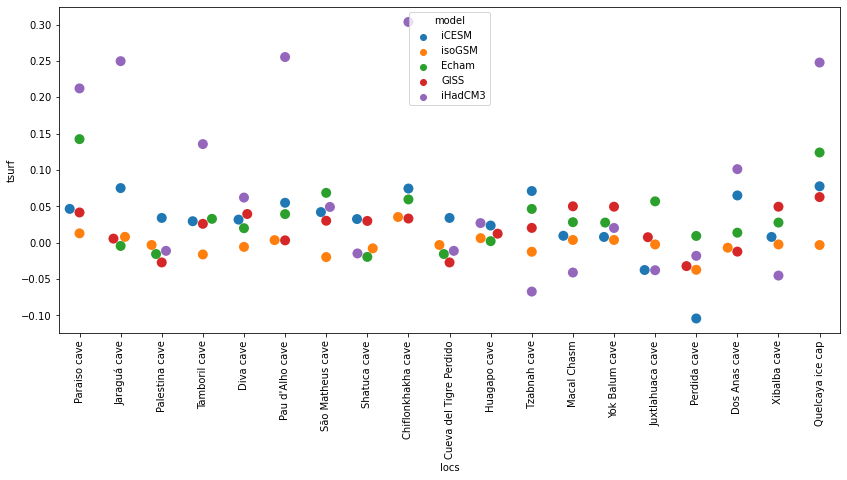

In [94]:
#10 years
plt.figure(figsize=(14,6))
si=10
sns.swarmplot(data=df,x="locs", y="tsurf", hue="model",size=si,marker='o')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'Paraiso cave'),
  Text(1, 0, 'Jaraguá cave'),
  Text(2, 0, 'Palestina cave'),
  Text(3, 0, 'Tamboril cave'),
  Text(4, 0, 'Diva cave'),
  Text(5, 0, "Pau d'Alho cave"),
  Text(6, 0, 'São Matheus cave'),
  Text(7, 0, 'Shatuca cave'),
  Text(8, 0, 'Chiflonkhakha cave'),
  Text(9, 0, 'Cueva del Tigre Perdido'),
  Text(10, 0, 'Huagapo cave'),
  Text(11, 0, 'Tzabnah cave'),
  Text(12, 0, 'Macal Chasm'),
  Text(13, 0, 'Yok Balum cave'),
  Text(14, 0, 'Juxtlahuaca cave'),
  Text(15, 0, 'Perdida cave'),
  Text(16, 0, 'Dos Anas cave'),
  Text(17, 0, 'Xibalba cave'),
  Text(18, 0, 'Quelcaya ice cap')])

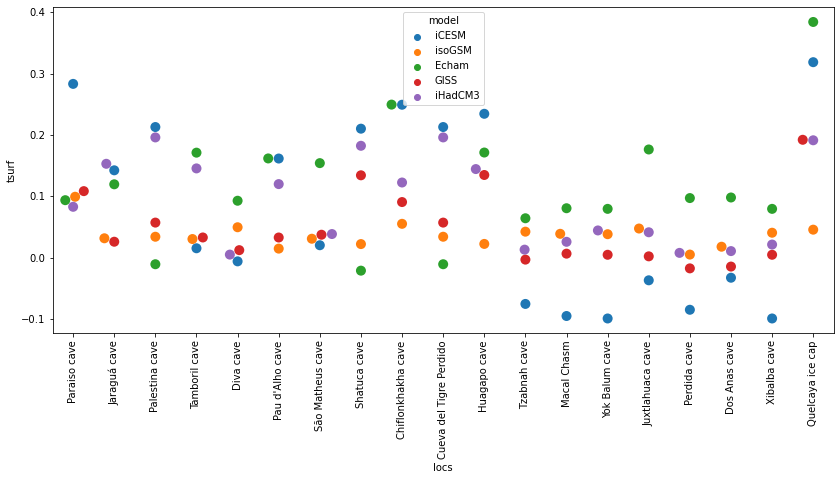

In [75]:
plt.figure(figsize=(14,6))
si=10
sns.swarmplot(data=df,x="locs", y="tsurf", hue="model",size=si,marker='o')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'Paraiso cave'),
  Text(1, 0, 'Jaraguá cave'),
  Text(2, 0, 'Palestina cave'),
  Text(3, 0, 'Tamboril cave'),
  Text(4, 0, 'Diva cave'),
  Text(5, 0, "Pau d'Alho cave"),
  Text(6, 0, 'São Matheus cave'),
  Text(7, 0, 'Shatuca cave'),
  Text(8, 0, 'Chiflonkhakha cave'),
  Text(9, 0, 'Cueva del Tigre Perdido'),
  Text(10, 0, 'Huagapo cave'),
  Text(11, 0, 'Tzabnah cave'),
  Text(12, 0, 'Macal Chasm'),
  Text(13, 0, 'Yok Balum cave'),
  Text(14, 0, 'Juxtlahuaca cave'),
  Text(15, 0, 'Perdida cave'),
  Text(16, 0, 'Dos Anas cave'),
  Text(17, 0, 'Xibalba cave'),
  Text(18, 0, 'Quelcaya ice cap')])

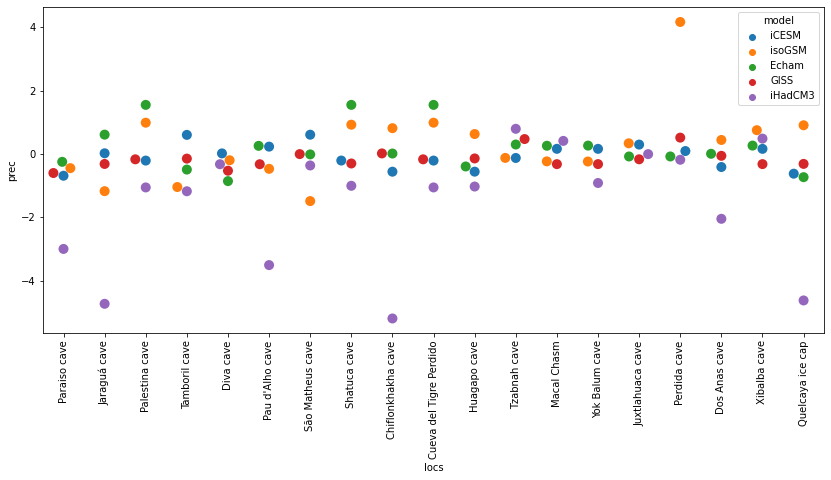

In [95]:
#10 years
plt.figure(figsize=(14,6))
si=10
sns.swarmplot(data=df,x="locs", y="prec", hue="model",size=si,marker='o')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'Paraiso cave'),
  Text(1, 0, 'Jaraguá cave'),
  Text(2, 0, 'Palestina cave'),
  Text(3, 0, 'Tamboril cave'),
  Text(4, 0, 'Diva cave'),
  Text(5, 0, "Pau d'Alho cave"),
  Text(6, 0, 'São Matheus cave'),
  Text(7, 0, 'Shatuca cave'),
  Text(8, 0, 'Chiflonkhakha cave'),
  Text(9, 0, 'Cueva del Tigre Perdido'),
  Text(10, 0, 'Huagapo cave'),
  Text(11, 0, 'Tzabnah cave'),
  Text(12, 0, 'Macal Chasm'),
  Text(13, 0, 'Yok Balum cave'),
  Text(14, 0, 'Juxtlahuaca cave'),
  Text(15, 0, 'Perdida cave'),
  Text(16, 0, 'Dos Anas cave'),
  Text(17, 0, 'Xibalba cave'),
  Text(18, 0, 'Quelcaya ice cap')])

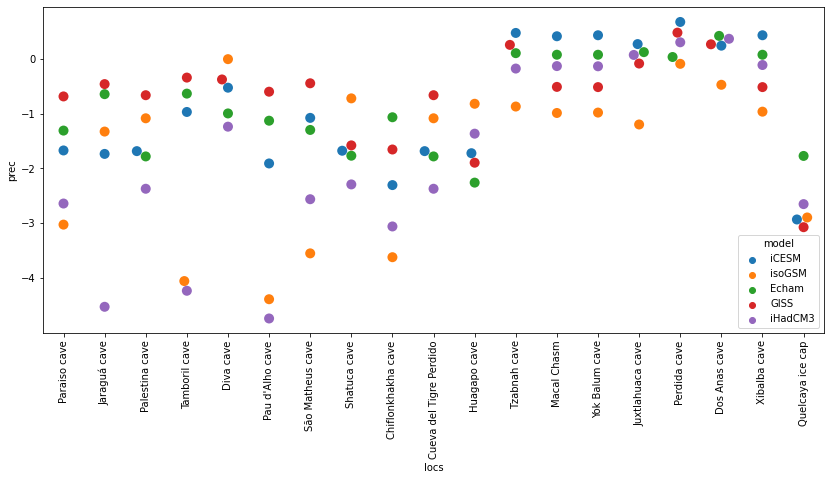

In [76]:
plt.figure(figsize=(14,6))
si=10
sns.swarmplot(data=df,x="locs", y="prec", hue="model",size=si,marker='o')
plt.xticks(rotation=90)

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(25,6))
models=['iCESM','Echam','GISS','iHadCM3','isoGSM']

#titles=['SNR 5 (single timescale)','SNR 1 (single timescale)','SNR 5 (multi timescale)','SNR 1 (multi timescale)']
ylabels=['RMSE','Corr','CE']

savename=None
mets=['RMSE','Corr','RE',]

basepath='/home/mchoblet/paleoda/results/experiments/thesis_5_4/'

for i in range(3):
    #title=titles[i]
    ax1=axs.flatten()[i]
    name='Correlation'
    if i==2:
        legend='auto'
    else:
        legend=False
    df=multi_model_dataframe(basepath=basepath,metric=('tsurf_'+mets[i]))
    #import pdb
    #pdb.set_trace()
    
    ax=sns.swarmplot(data=df,x="model", y="metric", hue="prior",size=si,marker='o',ax=ax1,legend=legend)
    sns.set(style='ticks', context='talk')
    ax=sns.swarmplot(data=df,x="model", y="metric", hue="model",size=si,marker='.',ax=ax1,legend=False)
   
    ax1.set_xticks(np.arange(len(models)),models,fontsize=16)
    ax1.set_xlabel('',fontsize=20)
    ax1.set_ylabel('',fontsize=20)
    ax1.set_title(mets[i],fontsize=25)
    ax1.tick_params(axis='y', labelsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)